In [56]:
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import tensorflow_addons ad tfa
from tensorflow.keras.optimizers import RMSprop, Nadam
from training_functions import plot_training

SyntaxError: invalid syntax (<ipython-input-56-94ceebe6a8a5>, line 6)

In [55]:
pip install tensorflow-addons

Note: you may need to restart the kernel to use updated packages.


# Method #2 Using candidate observations for training

In [2]:
learning_data = pd.read_csv('data/learning_data.csv')

In [3]:
# Drop columns corresponding to data labels, false positive flags, candidatite ids, observation dates
# Keeping telescope orientation for the first trial run
candidate_exoplanet_data = learning_data.drop(columns=['koi_disposition',
                                             'koi_fpflag_nt', 
                                             'koi_fpflag_ss',
                                             'koi_fpflag_co',
                                             'koi_fpflag_ec',
                                             'koi_tce_plnt_num',
                                             'koi_time0bk',
                                             'koi_time0bk_err1',
                                             'koi_time0bk_err2'])
candidate_exoplanet_labels = learning_data['koi_disposition'].replace({
    'FALSE POSITIVE':0,
    'CONFIRMED':1})

In [7]:
display(candidate_exoplanet_data)
display(candidate_exoplanet_labels)
display(candidate_exoplanet_data.info())

,Unnamed: 0,koi_period,koi_period_err1,koi_period_err2,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,0,54.418383,2.479000e-04,-2.479000e-04,0.586,0.059,-0.443,4.50700,0.11600,-0.11600,...,-81,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,1,19.899140,1.490000e-05,-1.490000e-05,0.969,5.126,-0.077,1.78220,0.03410,-0.03410,...,-176,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
2,2,1.736952,2.630000e-07,-2.630000e-07,1.276,0.115,-0.092,2.40641,0.00537,-0.00537,...,-174,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
3,3,2.525592,3.760000e-06,-3.760000e-06,0.701,0.235,-0.478,1.65450,0.04200,-0.04200,...,-211,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509
4,4,4.134435,1.050000e-05,-1.050000e-05,0.762,0.139,-0.532,3.14020,0.06730,-0.06730,...,-232,4.486,0.054,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5299,6983,21.513523,2.714000e-04,-2.714000e-04,2.441,0.821,-0.302,77.98300,0.89900,-0.89900,...,-141,3.508,0.187,-0.153,3.318,0.665,-0.813,287.46786,37.966640,10.630
5300,6986,8.589871,1.846000e-04,-1.846000e-04,0.765,0.023,-0.541,4.80600,0.63400,-0.63400,...,-152,4.296,0.231,-0.189,1.088,0.313,-0.228,298.74921,46.973351,14.478
5301,6987,0.527699,1.160000e-07,-1.160000e-07,1.252,0.051,-0.049,3.22210,0.01740,-0.01740,...,-166,4.529,0.035,-0.196,0.903,0.237,-0.079,297.18875,47.093819,14.082
5302,6989,0.681402,2.430000e-06,-2.430000e-06,0.147,0.309,-0.147,0.86500,0.16200,-0.16200,...,-236,4.447,0.056,-0.224,1.041,0.341,-0.114,294.16489,47.176281,15.385


0       1
1       0
2       0
3       1
4       1
       ..
5299    0
5300    0
5301    0
5302    0
5303    0
Name: koi_disposition, Length: 5304, dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5304 entries, 0 to 5303
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         5304 non-null   int64  
 1   koi_period         5304 non-null   float64
 2   koi_period_err1    5304 non-null   float64
 3   koi_period_err2    5304 non-null   float64
 4   koi_impact         5304 non-null   float64
 5   koi_impact_err1    5304 non-null   float64
 6   koi_impact_err2    5304 non-null   float64
 7   koi_duration       5304 non-null   float64
 8   koi_duration_err1  5304 non-null   float64
 9   koi_duration_err2  5304 non-null   float64
 10  koi_depth          5304 non-null   float64
 11  koi_depth_err1     5304 non-null   float64
 12  koi_depth_err2     5304 non-null   float64
 13  koi_prad           5304 non-null   float64
 14  koi_prad_err1      5304 non-null   float64
 15  koi_prad_err2      5304 non-null   float64
 16  koi_teq            5304 

None

## Split the data between training and validation sets

In [8]:
# Split the data into training and validation sets
training_data, validation_data, \
training_labels, validation_labels = train_test_split(
    candidate_exoplanet_data,
    candidate_exoplanet_labels,
    random_state=1
)

print(training_data.shape)
print(training_labels.shape)
print(validation_data.shape)
print(validation_labels.shape)

(3978, 33)
(3978,)
(1326, 33)
(1326,)


## Scale the features using the training data

In [10]:
feature_scaler = StandardScaler().fit(training_data)

training_data = feature_scaler.transform(training_data)
validation_data = feature_scaler.transform(validation_data)

print(training_data.shape)
print(validation_data.shape)

(3978, 33)
(1326, 33)


In [54]:
# build and compile the neural network
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation = tfa.activations.mish,input_dim=33),
    tf.keras.layers.Dense(128,activation = tfa.activations.mish),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model.compile(
    optimizer = tf.keras.optimizers.Nadam(learning_rate=.001),
    loss = 'binary_crossentropy',
    metrics = ['accuracy'])

NameError: name 'tfa' is not defined

In [52]:
history = model.fit(
    training_data,
    training_labels,
    validation_data = (validation_data, validation_labels),
    epochs=1000,
    batch_size=221,
    shuffle=True)

Epoch 1/1000
18/18 [==============================] - 1s 8ms/step - loss: 0.4839 - accuracy: 0.8213 - val_loss: 0.3421 - val_accuracy: 0.8801
Epoch 2/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.3037 - accuracy: 0.8831 - val_loss: 0.2609 - val_accuracy: 0.8952
Epoch 3/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.2560 - accuracy: 0.9012 - val_loss: 0.2429 - val_accuracy: 0.9035
Epoch 4/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.2352 - accuracy: 0.9082 - val_loss: 0.2321 - val_accuracy: 0.9103
Epoch 5/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.2206 - accuracy: 0.9138 - val_loss: 0.2226 - val_accuracy: 0.9125
Epoch 6/1000
18/18 [==============================] - 0s 3ms/step - loss: 0.2081 - accuracy: 0.9175 - val_loss: 0.2128 - val_accuracy: 0.9140
Epoch 7/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.1960 - accuracy: 0.9218 - val_loss: 0.2067 - val_accuracy: 0.9193
Epoch 

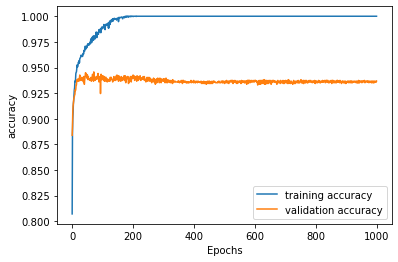

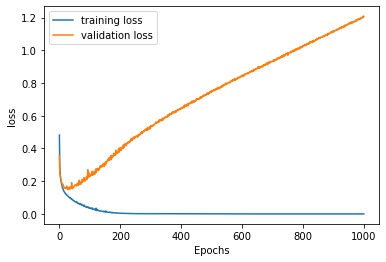

In [50]:
plot_training(history, 'accuracy')
plot_training(history, 'loss')